#Часть 2
1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

# Реализуемая задача:
## Локализация

# Ход работы

## Клонирование репозитория с датасетом

In [192]:
!git clone -b master https://github.com/dimilka/Dataset_Lab3.git

fatal: destination path 'Dataset_Lab3' already exists and is not an empty directory.


## Установка библиотек

In [193]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [194]:
import sys
sys.path.append('/content/Dataset_Lab3/src/data')

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используемое устройство:", device)

Используемое устройство: cpu


## Формирование датасета

В репозитории информация об изображениях разбита на два txt файла:

1. id изображения - расположение изображения
2. id изображения - координаты точек рамки

Объединю их в датафрей.

### Чтение txt файлов

In [195]:
import pandas as pd


images_df = pd.read_csv(
    "/content/Dataset_Lab3/src/data/images.txt",
    sep=" ",
    header=None,
    names=["id", "img_path"])

bboxes_df = pd.read_csv(
    "/content/Dataset_Lab3/src/data/bounding_boxes.txt",
    sep=" ",
    header=None,
    names=["id", "x", "y", "w", "h"])

# Проверка первых строк
print("Images DataFrame:")
print(images_df.head(3))

print("\nBounding Boxes DataFrame:")
print(bboxes_df.head(3))

Images DataFrame:
   id                                           img_path
0   1  001.Black_footed_Albatross/Black_Footed_Albatr...
1   2  001.Black_footed_Albatross/Black_Footed_Albatr...
2   3  001.Black_footed_Albatross/Black_Footed_Albatr...

Bounding Boxes DataFrame:
   id      x      y      w      h
0   1   60.0   27.0  325.0  304.0
1   2  139.0   30.0  153.0  264.0
2   3   14.0  112.0  388.0  186.0


### Объединение

In [196]:
df = pd.merge(images_df, bboxes_df, on="id")
df["full_img_path"] = "src/data/images/" + df["img_path"]

def change_type(name):
  df[name] = list(map(int, df[name]))

change_type("x")
change_type("y")
change_type("w")
change_type("h")

df = df.drop(columns=['id'])

df["x2"] = df.loc[:,['x','w']].sum(axis=1)
df["y2"] = df.loc[:,['y','h']].sum(axis=1)

df = df.drop(columns=['w'])
df = df.drop(columns=['h'])


df = df.sample(500)
df.head(5)

,img_path,x,y,full_img_path,x2,y2
4732,082.Ringed_Kingfisher/Ringed_Kingfisher_0079_7...,195,107,src/data/images/082.Ringed_Kingfisher/Ringed_K...,443,271
4649,080.Green_Kingfisher/Green_Kingfisher_0045_710...,93,87,src/data/images/080.Green_Kingfisher/Green_Kin...,214,272
2865,050.Eared_Grebe/Eared_Grebe_0048_34175.jpg,174,67,src/data/images/050.Eared_Grebe/Eared_Grebe_00...,464,280
3890,067.Anna_Hummingbird/Anna_Hummingbird_0118_557...,81,57,src/data/images/067.Anna_Hummingbird/Anna_Humm...,435,284
10787,184.Louisiana_Waterthrush/Louisiana_Waterthrus...,279,55,src/data/images/184.Louisiana_Waterthrush/Loui...,455,206


# Гиперпараметры

In [197]:
data_dir = '/content/Dataset_Lab3/'

device = "cuda"

batch_size = 16
img_size = 140

lr = 0.001
epochs = 40
model_name = "efficientnet_b0" #b3, b5, b7; resnet34, resnet50,

num_cor = 4

# Загрузка данных

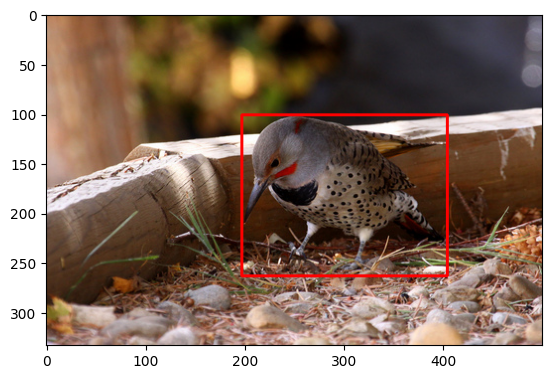

In [198]:
row = df.iloc[56]
image = cv2.imread(data_dir + row.full_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt1 = (row.x, row.y)
pt2 = (row.x2, row.y2)
bound_box = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bound_box);

In [199]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Аугментация данных

При повороте картинки рамку тоже надо поворачивать.

In [200]:
import albumentations as A

In [201]:
train_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

val_augs = A.Compose([
    A.Resize(img_size, img_size),
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

# Класс для обработки датасета

In [202]:
class ObjectLocationDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    x = row.x
    y = row.y
    x2 = row.x2
    y2 = row.y2

    bbox = [[x, y, x2, y2]]  # to satisfy format of augmentation

    img_path = data_dir + row.full_img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
      img = data["image"]
      bbox = data["bboxes"][0]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0 # (height, width, channel) -> (channel, height, width)
    bbox = torch.Tensor(bbox)

    return img, bbox


In [203]:
trainset = ObjectLocationDataset(train_df, train_augs)
valset = ObjectLocationDataset(val_df, val_augs)

In [204]:
print(f"Total examples in the train set: {len(trainset)}")
print(f"Total examples in the validation set: {len(valset)}")

Total examples in the train set: 400
Total examples in the validation set: 100


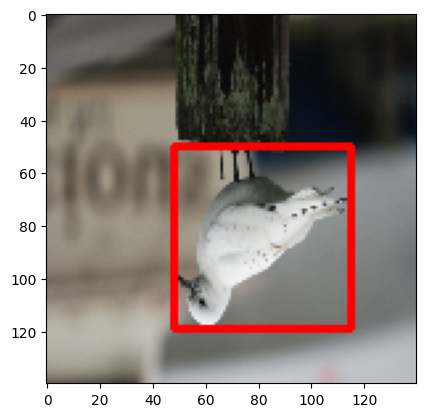

In [205]:
img, bbox = trainset[16]
x, y, x2, y2 = bbox

pt1 = (int(x), int(y))
pt2 = (int(x2), int(y2))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img);

# Разбиение датасета по батчам

In [206]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)


In [207]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 25
Total no. batches in validloader : 7


In [208]:
for images, bboxes in trainloader:
  break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Создание модели

In [209]:
from torch import nn
import timm

In [210]:
class ObjectLocationModel(nn.Module):
  def __init__(self):
    super(ObjectLocationModel, self).__init__()

    self.backbone = timm.create_model(model_name, pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes is not None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [213]:
model = ObjectLocationModel()
model.to(device)

In [215]:
random_img = torch.rand(1,3,140,140).to(device)
model(random_img).shape

torch.Size([1, 4])

# Функции для подсчета потерь

In [216]:
def train_func(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(device), gt_bboxes.to(device)

    bboxes, loss = model(images, gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [217]:
def eval_func(model, dataloader):
  total_loss = 0.0
  model.eval() # Dropout OFF

  with torch.no_grad():

    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(device), gt_bboxes.to(device)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)


# Обучение модели

In [218]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [219]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_func(model, trainloader, optimizer)
  val_loss = eval_func(model, validloader)

  if val_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("Weights Are Saved")
    best_valid_loss = val_loss

  print(f"Epoch: {i+1} train loss {train_loss} validation loss: {val_loss}")

  0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Примеры

In [ ]:
import utils

In [220]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
  image, gt_bbox = valset[19] # (c, h, w)
  image = image.unsqueeze(0).to(device) # (batch_size, c, h, w)

  out_bbox = model(image)
  utils.compare_plots(image, gt_bbox, out_bbox)

# green - ground truth, red - prediction

<ipython-input-220-cefa561cbeaf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'